![image info](https://ineuron.ai/images/ineuron-logo.png)

# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("./data/Travel.csv")

# Print shape of dataset
print(df.shape)

(4888, 20)


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Spelling mistake

In [2]:
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')



#### Check Null Values

In [3]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Age 4.62357 % missing values
TypeofContact 0.51146 % missing values
DurationOfPitch 5.13502 % missing values
NumberOfFollowups 0.92062 % missing values
PreferredPropertyStar 0.53191 % missing values
NumberOfTrips 2.86416 % missing values
NumberOfChildrenVisiting 1.35025 % missing values
MonthlyIncome 4.76678 % missing values


**What does NaN mean?**

**Ans:** Missing Values in a DataFrame

**Why might a value be missing?** 

**Ans:** When considering the potential impact of the missing data on the Dataset, it is important to consider the underlying reasons for why the data are missing
Missing data are of three categories:
* Missing completely at random (MCAR)
* Missing at random (MAR).
* Missing not at random (MNAR). 

Here it is MCAR type of missing values in dataset which are Missing completely at Random. 

When we make this assumption, we are assuming the missing data is completely unrelated to the other information in the data.

In [4]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude='object').describe()



,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


### Imputing Null values

* **Impute Median value for Age column**
* **Impute Mode for Type of Contract**
* **Impute Median for Duration of Pitch**
* **Impute Mode for NumberofFollowup as it is Discrete feature**
* **Impute Mode for PreferredPropertyStar**
* **Impute Median for NumberofTrips**
* **Impute Mode for NumberOfChildrenVisiting**
* **Impute Median for MonthlyIncome**

In [5]:
#Age
df.Age.fillna(df.Age.median(), inplace=True)

#TypeofContract
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)

#DurationOfPitch
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)

#NumberOfFollowups
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)

#PreferredPropertyStar
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)

#NumberOfTrips
df.NumberOfTrips.fillna(0, inplace=True)

#NumberOfChildrenVisiting
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True)

#MonthlyIncome
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)



### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [6]:
df.duplicated().sum()



0

**Remove Customer ID from the dataset as it cannot used in Model Training**

**Remove Gender Column as it doesn't correlate with target variable which is ProdTaken**

In [7]:
df.drop('CustomerID', inplace=True, axis=1)
df.drop('Gender', inplace=True, axis=1)



# Feature Engineering

## Feature Extraction

In [8]:
# create new column for feature
df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)



### Type of Features

**Numeric Features**

In [9]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))




Num of Numerical Features : 12


**Categorical Features**

In [10]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))



Num of Categorical Features : 5


**Discrete Features**

In [11]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))



Num of Discrete Features : 9


**Continues Features**

In [12]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))



Num of Continuous Features : 3


### Multicollinearity Check
#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [13]:
# for multicollinearity, we will be using numerical features

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):   
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif


In [15]:
num_features

['ProdTaken',
 'Age',
 'CityTier',
 'DurationOfPitch',
 'NumberOfFollowups',
 'PreferredPropertyStar',
 'NumberOfTrips',
 'Passport',
 'PitchSatisfactionScore',
 'OwnCar',
 'MonthlyIncome',
 'TotalVisiting']

In [16]:
compute_vif(num_features, df)



,Variable,VIF
0,ProdTaken,1.160212
1,Age,1.338181
2,CityTier,1.016978
3,DurationOfPitch,1.010489
4,NumberOfFollowups,1.177131
5,PreferredPropertyStar,1.016637
6,NumberOfTrips,1.058434
7,Passport,1.082667
8,PitchSatisfactionScore,1.012579
9,OwnCar,1.012123


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 
 
**- This Dataset Doesnt have any MultiCollinearity**

### Check Outlier and Capping it

**Why outliers?**
* Data Entry error : Human error. 
* Measurement error: Instrument error. 
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

**Why IQR For Outlier Handling?**
* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

In [17]:
continuous_features

['Age', 'DurationOfPitch', 'MonthlyIncome']

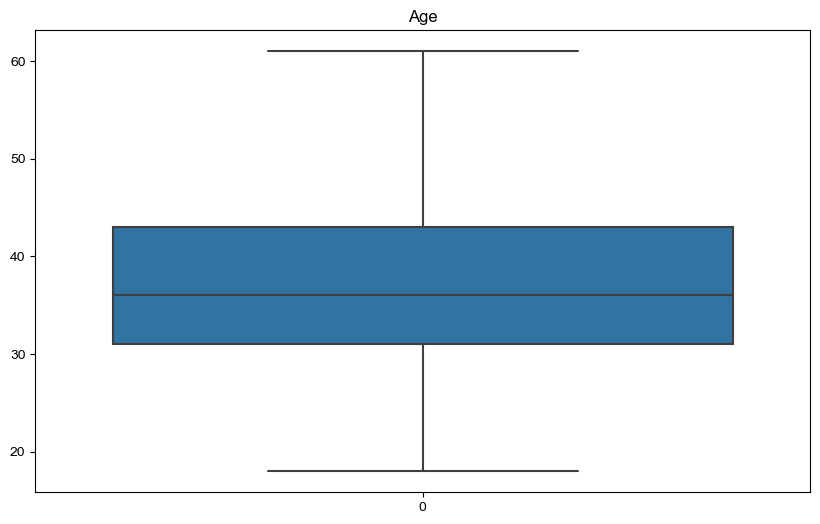

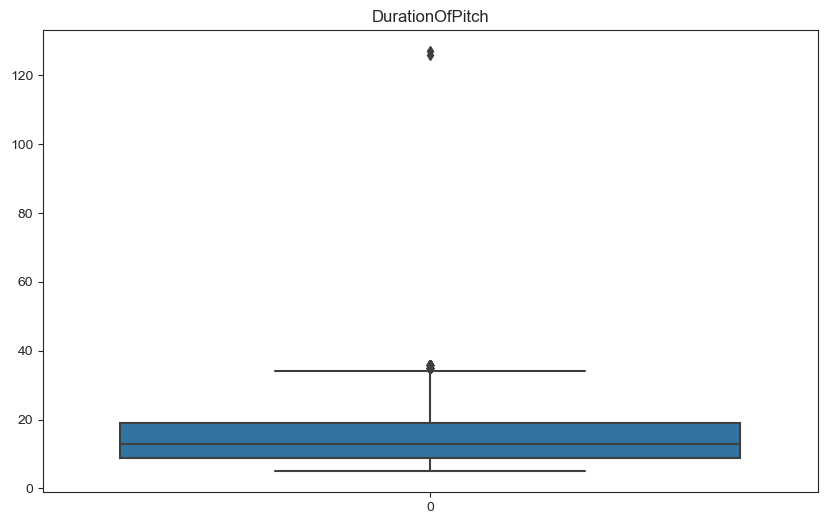

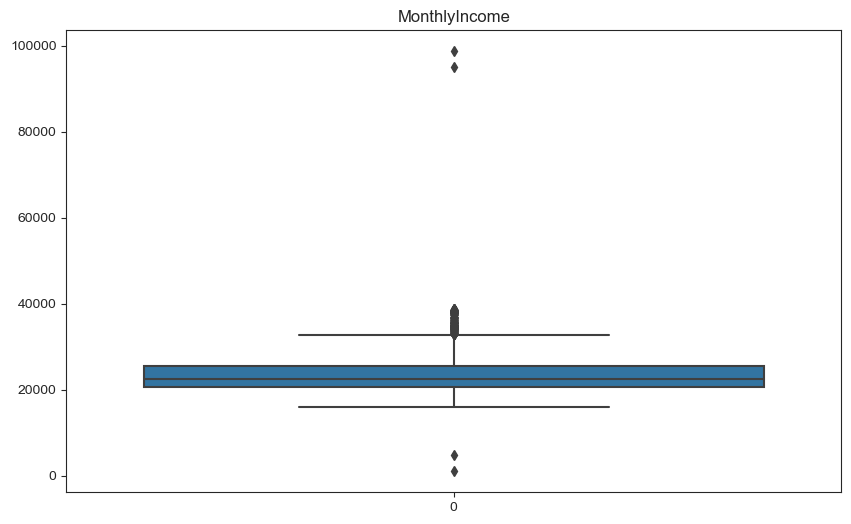

In [18]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        plt.title(str(i))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])
        

**Detecting Outlier and Capping it**

In [19]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df



**Why are we capping it and why not trim it ?**
* Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

* In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [20]:
for col in continuous_features:
         detect_outliers(col)
        


 #### Age ####
percentile25 31.0
percentile75 43.0
Upper limit 61.0
Lower limit 13.0

 #### DurationOfPitch ####
percentile25 9.0
percentile75 19.0
Upper limit 34.0
Lower limit -6.0

 #### MonthlyIncome ####
percentile25 20485.0
percentile75 25424.75
Upper limit 32834.375
Lower limit 13075.375


**Checking Skewness after Outlier Capping**

In [21]:
df[continuous_features].skew(axis=0, skipna=True)



Age                0.415796
DurationOfPitch    0.942638
MonthlyIncome      0.726163
dtype: float64

## Feature Transformation

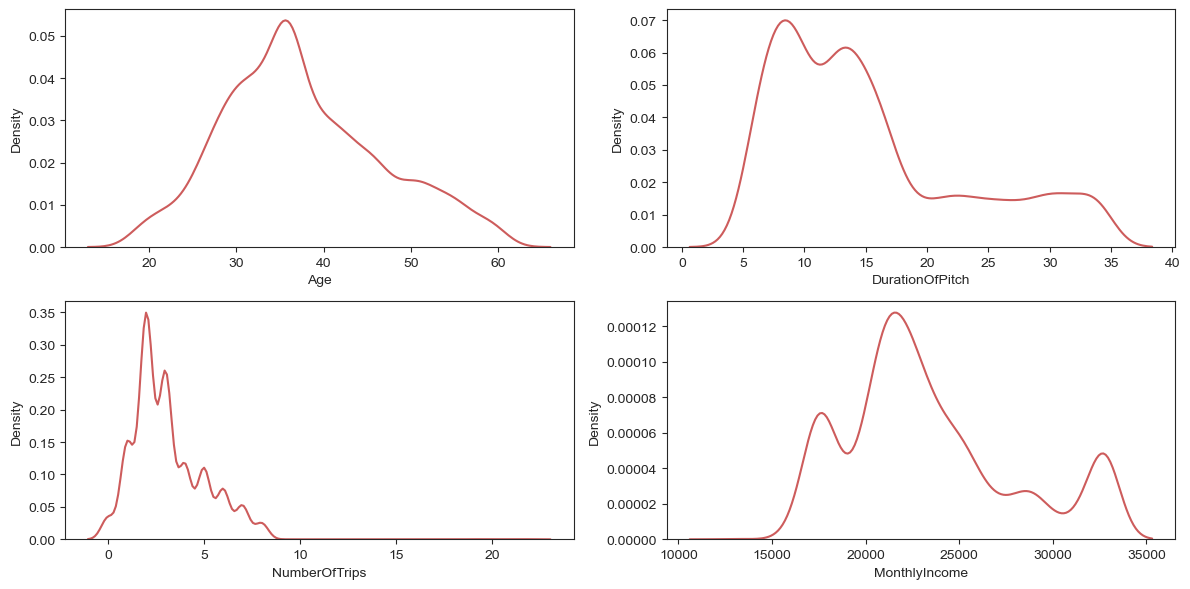

In [22]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()
    
    

- Positiviely Skewed : DurationOfPitch, NumberOfTrips

There are few outliers in all columns

**Log Transformation**

**What is Skewness ?**

* Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve, or normal distribution, in a set of data. If the curve is shifted to the left or to the right, it is said to be skewed. Skewness can be quantified as a representation of the extent to which a given distribution varies from a normal distribution. A normal distribution has a skew of zero

In [23]:
#Applying Log Transformation
df[['DurationOfPitch','NumberOfTrips']] = df[['DurationOfPitch','NumberOfTrips']].apply(np.log1p)



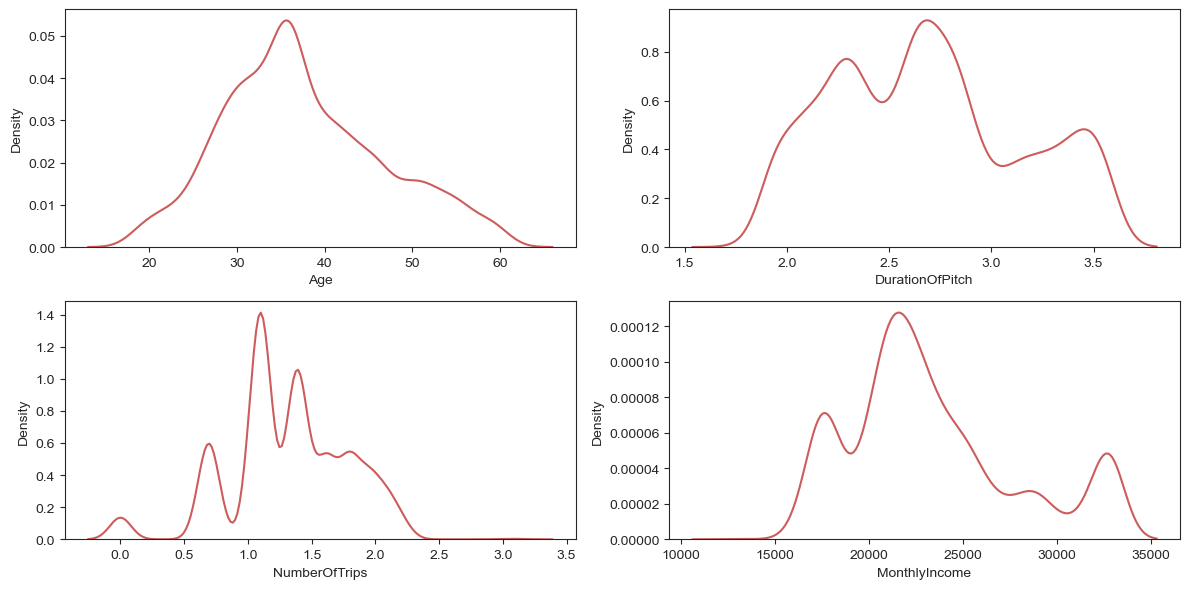

In [24]:
# distribution of data after Transformation
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Age', 'DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()
    
    

In [25]:
df.shape

(4888, 17)

### Split X and Y

In [26]:
from sklearn.model_selection import train_test_split
X = df.drop(['ProdTaken'], axis=1)
y = df['ProdTaken']


In [27]:
X.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalVisiting
0,41.0,Self Enquiry,3,1.945910,Salaried,3.0,Deluxe,3.0,Unmarried,0.693147,1,2,1,Manager,20993.0,3.0
1,49.0,Company Invited,1,2.708050,Salaried,4.0,Deluxe,4.0,Divorced,1.098612,0,3,1,Manager,20130.0,5.0
2,37.0,Self Enquiry,1,2.197225,Free Lancer,4.0,Basic,3.0,Unmarried,2.079442,1,3,0,Executive,17090.0,3.0
3,33.0,Company Invited,1,2.302585,Salaried,3.0,Basic,3.0,Divorced,1.098612,1,5,1,Executive,17909.0,3.0
4,36.0,Self Enquiry,1,2.197225,Small Business,3.0,Basic,4.0,Divorced,0.693147,0,5,1,Executive,18468.0,2.0


In [28]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: ProdTaken, dtype: int64

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “ProdTaken” column.**


In [29]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())
    
    

TypeofContact : 2
Occupation : 4
ProductPitched : 5
MaritalStatus : 3
Designation : 5


## Feature Encoding and Scaling

 **One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [30]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [31]:
X.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalVisiting
0,41.0,Self Enquiry,3,1.945910,Salaried,3.0,Deluxe,3.0,Unmarried,0.693147,1,2,1,Manager,20993.0,3.0
1,49.0,Company Invited,1,2.708050,Salaried,4.0,Deluxe,4.0,Divorced,1.098612,0,3,1,Manager,20130.0,5.0
2,37.0,Self Enquiry,1,2.197225,Free Lancer,4.0,Basic,3.0,Unmarried,2.079442,1,3,0,Executive,17090.0,3.0
3,33.0,Company Invited,1,2.302585,Salaried,3.0,Basic,3.0,Divorced,1.098612,1,5,1,Executive,17909.0,3.0
4,36.0,Self Enquiry,1,2.197225,Small Business,3.0,Basic,4.0,Divorced,0.693147,0,5,1,Executive,18468.0,2.0


In [32]:
# Create Column Transformer with 3 types of transformers
cat_features = X.select_dtypes(include="object").columns
num_features = X.select_dtypes(exclude="object").columns


In [33]:
cat_features

Index(['TypeofContact', 'Occupation', 'ProductPitched', 'MaritalStatus',
       'Designation'],
      dtype='object')

In [34]:
num_features

Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'TotalVisiting'],
      dtype='object')

In [35]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
         ("OneHotEncoder", oh_transformer, cat_features),
          ("StandardScaler", numeric_transformer, num_features)
    ]
)


In [36]:
X= preprocessor.fit_transform(X)



In [37]:
X.shape

(4888, 30)

## Handling Imbalanced Dataset

* Handling Imbalanced Target Variable.
* Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

* SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class.

In [38]:
X.shape

(4888, 30)

In [44]:
y

0       1
1       0
2       1
3       0
4       0
       ..
4883    1
4884    1
4885    1
4886    1
4887    1
Name: ProdTaken, Length: 4888, dtype: int64

In [45]:
(y == 0).sum()

3968

In [46]:
(y == 1).sum()

920

In [40]:
from imblearn.combine import SMOTETomek, SMOTEENN


In [41]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)



In [43]:
X_res.shape

(7115, 30)

In [48]:
(y_res == 0).sum()

3210

In [47]:
(y_res == 1).sum()

3905

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [49]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((5692, 30), (1423, 30))

## Model Selection
* **Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

**Import Required packages for model trainin**

In [53]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [54]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
     "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

    
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))

    
    print('='*35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9817
- F1 score: 0.9817
- Precision: 0.9803
- Recall: 0.9855
- Roc Auc Score: 0.9815


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9396
- F1 score: 0.9395
- Precision: 0.9340
- Recall: 0.9538
- Roc Auc Score: 0.9386


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9236
- F1 score: 0.9237
- Precision: 0.9452
- Recall: 0.9149
- Roc Auc Score: 0.9246
----------------------------------
Model performance for Test set
- Accuracy: 0.9227
- F1 score: 0.9228
- Precision: 0.9450
- Recall: 0.9075
- Roc Auc Score: 0.9237


Logistic Regression
Model performance for Training 

**Results of All Models**

| Model Name      | Accuracy |
| ----------- | ----------- |
| Random Forest | 0.9824       |
|XGBClassifier   | 0.9796        |
| CatBoosting Classifier   | 0.9761        |
| K-Neighbors Classifier   | 0.9649        |
| Support Vector Classifier   | 0.9389        |
| Decision Tree   | 0.9396        |
| Gradient Boosting   | 0.9132        |
| AdaBoost Classifier   | 0.8714        |
| Logistic Regression   | 0.7941        |

**Here we can use Random Forest , XGBoost Classifier, CatBoost Classifier, and K-Neighbour Classifier for Hyper Parameter Tuning**

In [55]:
#Initialize few parameter for Hyperparamter tuning
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01],
              "max_depth": [5, 8, 12, 20, 30]}

In [56]:
# Models list for Hyperparameter tuning
randomcv_models = [('KNN', KNeighborsClassifier(), knn_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(), xgboost_params),
                   ('CatBoost', CatBoostClassifier(verbose=False), cat_params)
                   ]

In [57]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

### Retraining the Model with best Parameters

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, min_samples_split=2, max_features= 7, max_depth= 15),
    "K-Neighbors Classifier": KNeighborsClassifier(n_neighbors=2),
    "XGBClassifier": XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 1, n_jobs=-1), 
    "CatBoosting Classifier": CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc



    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
    
    print('----------------------------------')
    
    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
    
    print('='*35)
    print('\n')

| Model Name | Accuracy | Auc Score |
| ----------- | ----------- |-----------|
| K-Neighbors Classifier   | 0.9944   |0.9940 |
| CatBoosting Classifier   | 0.9937   | 0.9934 |
| XGBClassifier   | 0.9838        | 0.9836 |
| Random Forest | 0.9803      | 0.9801 |

## Plot Roc Auc Curve

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(n_estimators=200, min_samples_split=2, max_features= 7, max_depth= 15),
    'auc': 0.9801
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(n_estimators= 300, max_depth= 12, learning_rate= 0.1, colsample_bytree= 1, n_jobs=-1),
    'auc': 0.9836
},
{
    'label': 'KNN Classifier',
    'model': KNeighborsClassifier(n_neighbors=2),
    'auc': 0.9940 
},
{
    'label': 'CatBoost Classifier',
    'model': CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
    'auc': 0.9934
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.7, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(r"./images/auc.png")
plt.show()   # Display

### As Models have very high accuracy we can use cross validation score for further evaluation.

Cross-validation is a statistical method used to estimate the accuracy of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited.

Stratified kfold cross validation is an extension of regular kfold cross validation but specifically for classification problems where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset.

**Stratified K-fold Cross Validation Technique on 4 algorithm to know the exact Mean CV accuracy score**

In [ ]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
skfold = StratifiedKFold(n_splits= 10,shuffle= True,random_state= 42)

In [ ]:
cat_cv_result = cross_val_score(CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False),
                                X_test, y_test, cv=skfold,scoring="accuracy",n_jobs=-1)
cat_cv = cat_cv_result.mean()*100
print('CatBoost CV Mean Accuarcy Score is {}'.format(cat_cv))

In [ ]:
knn_cv_result = cross_val_score(KNeighborsClassifier(n_neighbors=2),
                                X_test, y_test, cv=skfold,scoring="accuracy",n_jobs=-1)
knn_cv = knn_cv_result.mean()*100
print('KNN Classifier CV Mean Accuarcy Score is {}'.format(knn_cv))

In [ ]:
rf_cv_result = cross_val_score(RandomForestClassifier(n_estimators=200, min_samples_split=2, max_features= 7,
                                                      max_depth= None), X_test, y_test, cv=skfold,scoring="accuracy",n_jobs=-1)
rf_cv = rf_cv_result.mean()*100
print('Random Forest Classifier CV Mean Accuarcy Score is {}'.format(rf_cv))

In [ ]:
xgb_cv_result = cross_val_score(XGBClassifier(n_estimators= 300, max_depth= 20, learning_rate= 0.1, colsample_bytree= 0.8,
                                              n_jobs=-1), X_test, y_test, cv=skfold,scoring="accuracy",n_jobs=-1)
xgb_cv = xgb_cv_result.mean()*100
print('XGB Classifier CV Mean Accuarcy Score is {}'.format(xgb_cv))

| Model Name      | Cross_val_score |
| ----------- | ----------- |
| CatBoosting Classifier   | 93.39%       |
|XGBClassifier   | 92.13%        |
| K-Neighbors Classifier   | 91.64%        |
| Random Forest | 91.56%       |

In [ ]:
best_model = CatBoostClassifier(max_depth= 12, learning_rate= 0.1,verbose=False)
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'CATBOOST'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

### Best Model is CatBoost Classifier with 99.37 % Accuracy and also performed well in Cross validation

In [ ]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(best_model, open('holidaypackagemodel.pkl', 'wb'))